# 1. Reducción imágenes NGC 55

In [16]:
#Paquetes necesarios: numpy, matplotlib y astropy
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.visualization import ZScaleInterval
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from photutils.segmentation import (SourceCatalog, deblend_sources, detect_sources, detect_threshold)

## Para B


In [3]:
#Abrimos las imágenes de ciencia de NGC 55 en flitro B, de 900 segundos de exposición
rawB1=fits.open('Grupo 5/Light_Mouse_click_position_B_900.000secs_00000051.fit')
rawB2=fits.open('Grupo 5/Light_Mouse_click_position_B_900.000secs_00000052.fit')
rawB3=fits.open('Grupo 5/Light_Mouse_click_position_B_900.000secs_00000053.fit')

In [4]:
#Veamos el header
rawB1[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 4096 / length of data axis 1                          
NAXIS2  =                 4096 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
OBSERVER= 'PUCV    '           / SBIGFITSEXT The name of the observer           
ORIGIN  = 'MAS500  '           / Description of location                        
TELESCOP= 'MAS500  '        

In [5]:
#Extraigamos las imágenes
dataB1=rawB1[0].data
dataB2=rawB2[0].data
dataB3=rawB3[0].data

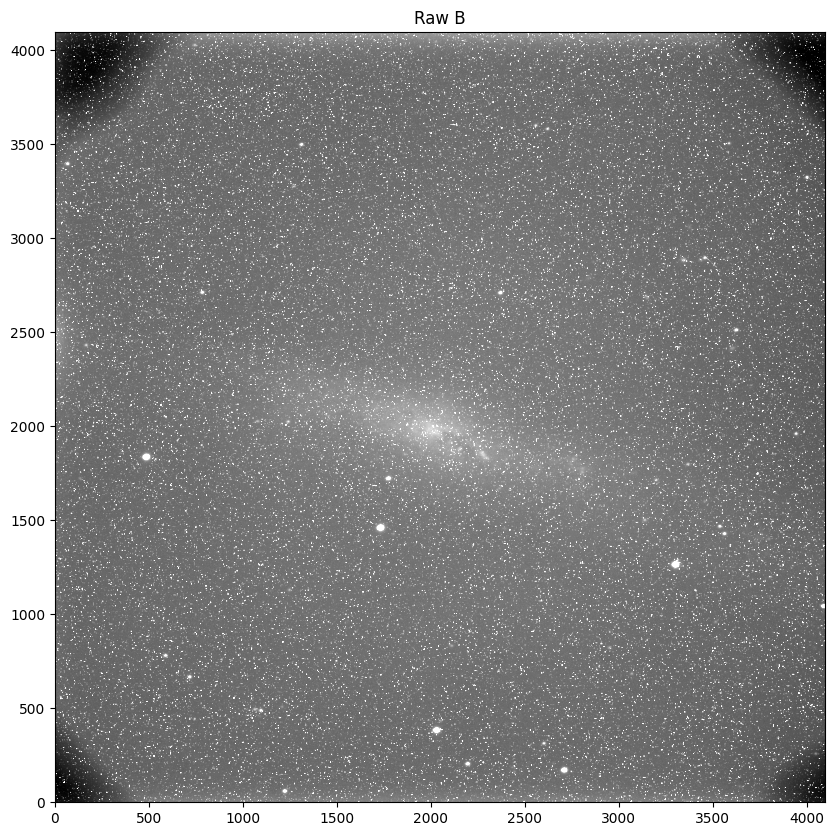

In [6]:
#Grafiquemos una imagen
zscale=ZScaleInterval(contrast=0.15)
min_value,max_value=zscale.get_limits(dataB1)

fig=plt.figure(figsize=(10,10))
plt.title('Raw B')
plt.imshow(dataB1,vmin=min_value,vmax=max_value,cmap='gray',origin='lower')
plt.show()

In [7]:
with fits.open('master_bias.fit') as hdul:
    master_bias = hdul[0].data
with fits.open('master_flatV_norm.fit') as hdul:
    master_flatV_norm = hdul[0].data    
with fits.open('master_flatB_norm.fit') as hdul:
    master_flatB_norm = hdul[0].data 
with fits.open('master_dark.fit') as hdul:
    master_dark = hdul[0].data

In [8]:
#Hagámos la reducción
#Ya que nuestro master dark es de 600 segundos igual que la imagen de ciencia, podemos restar directamente
#master dark y limpiar tanto el dark como el bias de las imágenes
# Evitamos divisiones por cero añadiendo un pequeño valor donde master_flatB_norm es cero
master_flatB_norm_safe = np.where(master_flatB_norm == 0, 1e-10, master_flatB_norm)

# Luego realizamos la división
redB1 = (dataB1 - master_dark) / master_flatB_norm_safe
redB2 = (dataB2 - master_dark) / master_flatB_norm_safe
redB3 = (dataB3 - master_dark) / master_flatB_norm_safe

In [9]:
#Combinemos nuestras imágenes reducidas, quitamos los bordes multiplicando por una máscara
bpm=fits.open('BPM.fit')[0].data
imagen_finalB=np.mean([redB1,redB2,redB3],axis=0)*bpm

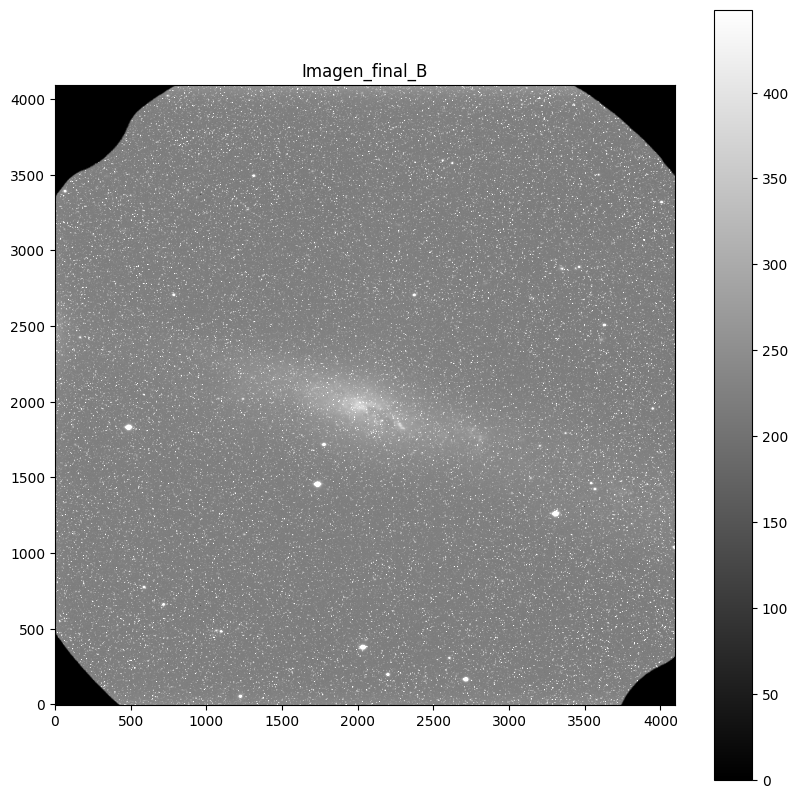

In [10]:
fig=plt.figure(figsize=(10,10))
zscale=ZScaleInterval(contrast=0.1)
min_value,max_value=zscale.get_limits(imagen_finalB)

plt.imshow(imagen_finalB,vmin=min_value,vmax=max_value,cmap='gray',origin='lower')
plt.title('Imagen_final_B')
plt.colorbar()
#plt.savefig('B')
plt.show()

## Para V

In [11]:
#Abrimos las imágenes de ciencia de NGC 55 en flitro B, de 900 segundos de exposición
rawV1=fits.open('Grupo 5/Light_Mouse_click_position_V_600.000secs_00000048.fit')
rawV2=fits.open('Grupo 5/Light_Mouse_click_position_V_600.000secs_00000049.fit')
rawV3=fits.open('Grupo 5/Light_Mouse_click_position_V_600.000secs_00000050.fit')

In [12]:
#Extraigamos las imágenes
dataV1=rawV1[0].data
dataV2=rawV2[0].data
dataV3=rawV3[0].data

In [13]:
#Hagámos la reducción
#Ya que nuestro master dark es de 600 segundos igual que la imagen de ciencia, podemos restar directamente
#master dark y limpiar tanto el dark como el bias de las imágenes
# Evitamos divisiones por cero añadiendo un pequeño valor donde master_flatB_norm es cero
master_flatV_norm_safe = np.where(master_flatV_norm == 0, 1e-10, master_flatV_norm)

# Luego realizamos la división
redV1 = (dataV1 - master_dark) / master_flatV_norm_safe
redV2 = (dataV2 - master_dark) / master_flatV_norm_safe
redV3 = (dataV3 - master_dark) / master_flatV_norm_safe

In [14]:
#Combinemos nuestras imágenes reducidas, quitamos los bordes multiplicando por una máscara
bpm=fits.open('BPM.fit')[0].data
imagen_finalV=np.mean([redV1,redV2,redV3],axis=0)*bpm

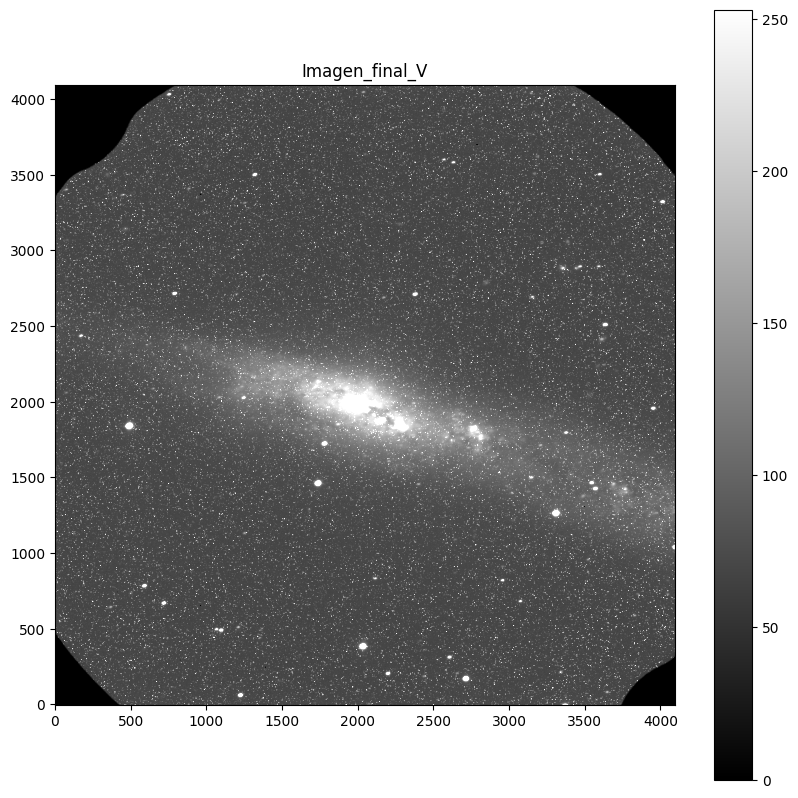

In [15]:
fig=plt.figure(figsize=(10,10))
zscale=ZScaleInterval(contrast=0.1)
min_value,max_value=zscale.get_limits(imagen_finalV)

plt.imshow(imagen_finalV,vmin=min_value,vmax=max_value,cmap='gray',origin='lower')
plt.title('Imagen_final_V')
plt.colorbar()
#plt.savefig('V')
plt.show()

si queremos generar la imagen a color debemos combinar las reducciones hechas por cada filtro

In [46]:
B=np.mean([redB1,redB2,redB3],axis=0)*bpm
V=np.mean([redV1,redV2,redV3],axis=0)*bpm
B[B < 0] = 0
V[V <0] = 0

#generamos la imagen para la bajanda R virtualmente promediando las imagenes que tenemos
R=np.mean([B,V],axis=0)

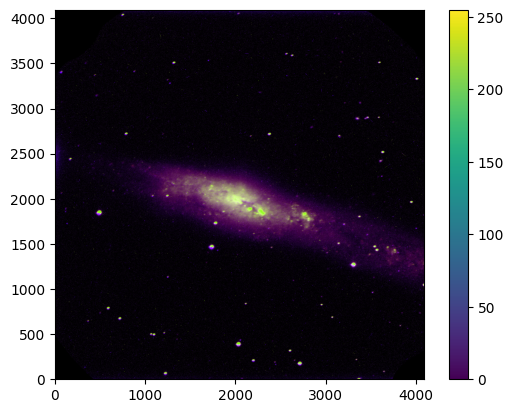

In [47]:
rgb= make_lupton_rgb(R,V,B,Q=3,minimum=[150,120,210],stretch=100)
plt.imshow(rgb, origin='lower')
plt.colorbar()
plt.savefig('rgb.png',dpi='figure')
plt.show()
plt.close()